# Financial Inclusion in Africa - Notebook

# Part 1 Data prep and cleaning

In [2]:
# Load packages
# dataframe and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
#from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
# Load data
df = pd.read_csv('Train.csv')

In [5]:
df.head()
# Column uniqueid is NOT unique. Only unique in combination with country

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [6]:
df.bank_account.head

<bound method NDFrame.head of 0        Yes
1         No
2        Yes
3         No
4         No
        ... 
23519     No
23520     No
23521     No
23522     No
23523     No
Name: bank_account, Length: 23524, dtype: object>

In [7]:
df.info()
# Many categorical variables -> need to create dummies
# bank_account = target = needs to be numerical as well (contains yes and no)
# No NaNs, which is nice!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


Data exploration was mainly done here: https://medium.com/analytics-vidhya/why-you-need-to-explore-your-data-how-you-can-start-13de6f29c8c1

Main takeaways: 14% have a bankaccount, 86% don't. Highly imbalanced. Might need tweaking for modelling!

In [8]:
# Bank account distribution among category levels
ctdf = df.select_dtypes(include='object').drop(["bank_account","uniqueid"], axis=1)
ctdf_y = df.bank_account


for column_name in ctdf.columns:
    print(pd.crosstab(ctdf[column_name], ctdf_y,normalize="index"))
    print("____________")


# Main takeaways:
# - No cellphone = most likely no bank account
# - Differences among countries
# - Small differences between rural and urban and also between genders. Smaller as expected. 
# education_level and job_type have a high influence and are POTENTIALLY correlated.
# Need to research banking practice in Africa !!!

pd.crosstab(ctdf.job_type, ctdf.education_level, normalize="index")

bank_account        No       Yes
country                         
Kenya         0.749341  0.250659
Rwanda        0.885175  0.114825
Tanzania      0.908308  0.091692
Uganda        0.913851  0.086149
____________
bank_account         No       Yes
location_type                    
Rural          0.883497  0.116503
Urban          0.821261  0.178739
____________
bank_account            No       Yes
cellphone_access                    
No                0.982867  0.017133
Yes               0.816203  0.183797
____________
bank_account                No       Yes
gender_of_respondent                    
Female                0.893205  0.106795
Male                  0.810304  0.189696
____________
bank_account                  No       Yes
relationship_with_head                    
Child                   0.913414  0.086586
Head of Household       0.822851  0.177149
Other non-relatives     0.894737  0.105263
Other relative          0.901198  0.098802
Parent                  0.940147  0.059853
S

education_level,No formal education,Other/Dont know/RTA,Primary education,Secondary education,Tertiary education,Vocational/Specialised training
job_type,,,,,,
Dont Know/Refuse to answer,0.142857,0.000000,0.595238,0.238095,0.015873,0.007937
Farming and Fishing,0.258225,0.000000,0.552472,0.162103,0.009741,0.017460
Formally employed Government,0.010336,0.005168,0.108527,0.335917,0.312661,0.227390
Formally employed Private,0.031280,0.001896,0.309953,0.251185,0.212322,0.193365
Government Dependent,0.530364,0.004049,0.372470,0.036437,0.032389,0.024291
Informally employed,0.201894,0.002859,0.608719,0.141147,0.031445,0.013936
No Income,0.185008,0.004785,0.499203,0.224880,0.074960,0.011164
Other Income,0.170370,0.002778,0.477778,0.263889,0.043519,0.041667
Remittance Dependent,0.195489,0.000791,0.378710,0.317768,0.068856,0.038385


In [9]:
plt.figure(figsize=(10,6))
sns.violinplot(x='bank_account',y="age",data=df, hue='sex', split='True', palette='rainbow')
plt.title("Violin Plot of Age by Class, Separated by Sex")


ValueError: Could not interpret input 'age'

<Figure size 1000x600 with 0 Axes>

/var/folders/jr/p21bhxh16zs45yz56c_h0pbw0000gn/T/ipykernel_41560/2241597730.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)


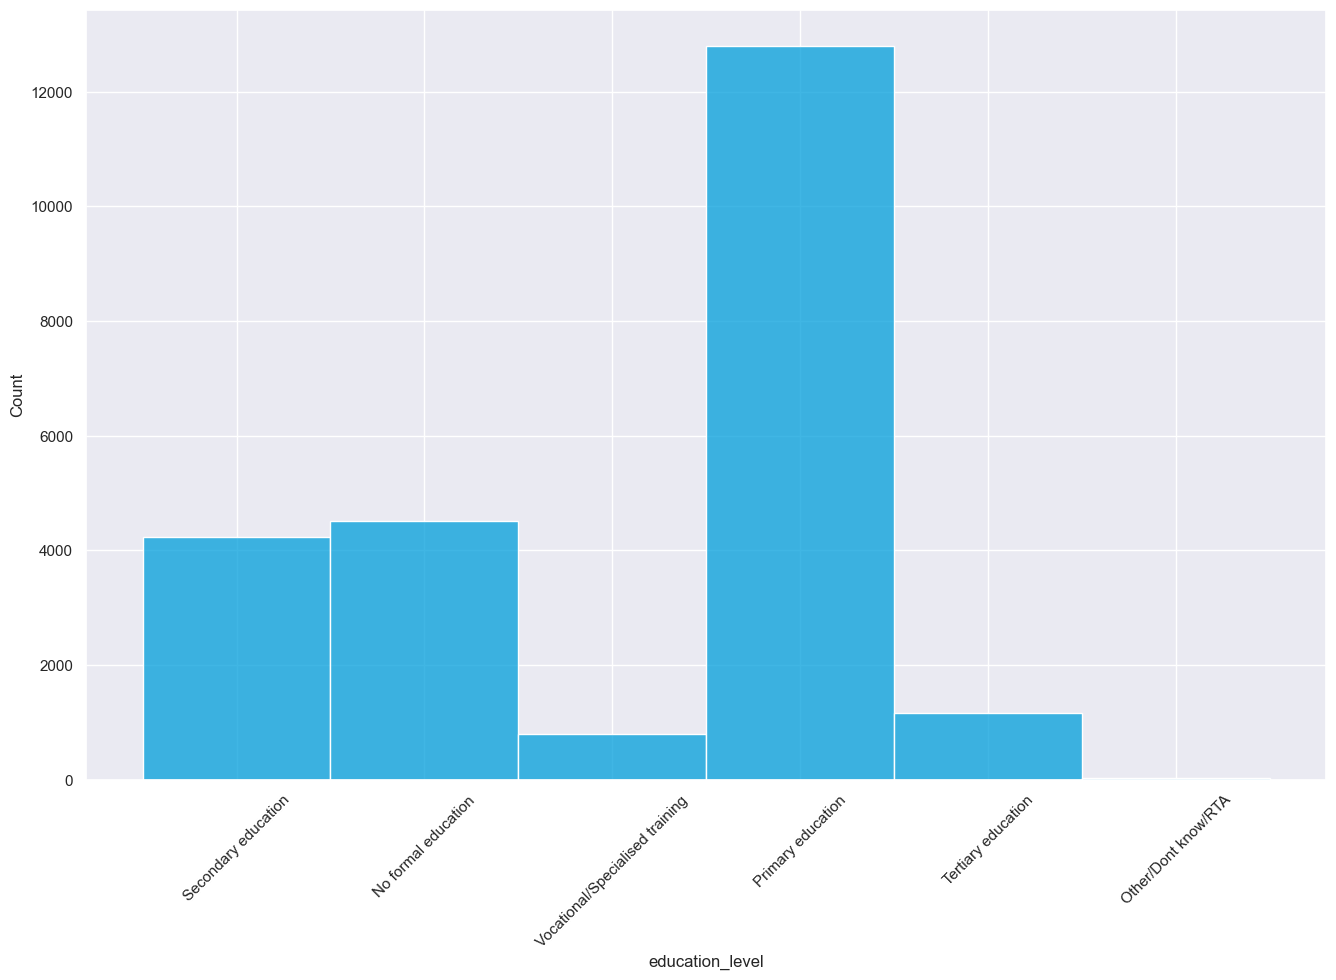

In [ ]:
# bank account education
sns.set(rc={'figure.figsize':(16,10)})
ax = sns.histplot(data=df, x="education_level", color="#009EDB", )
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)

plt.show()

/var/folders/jr/p21bhxh16zs45yz56c_h0pbw0000gn/T/ipykernel_41560/3754852061.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)


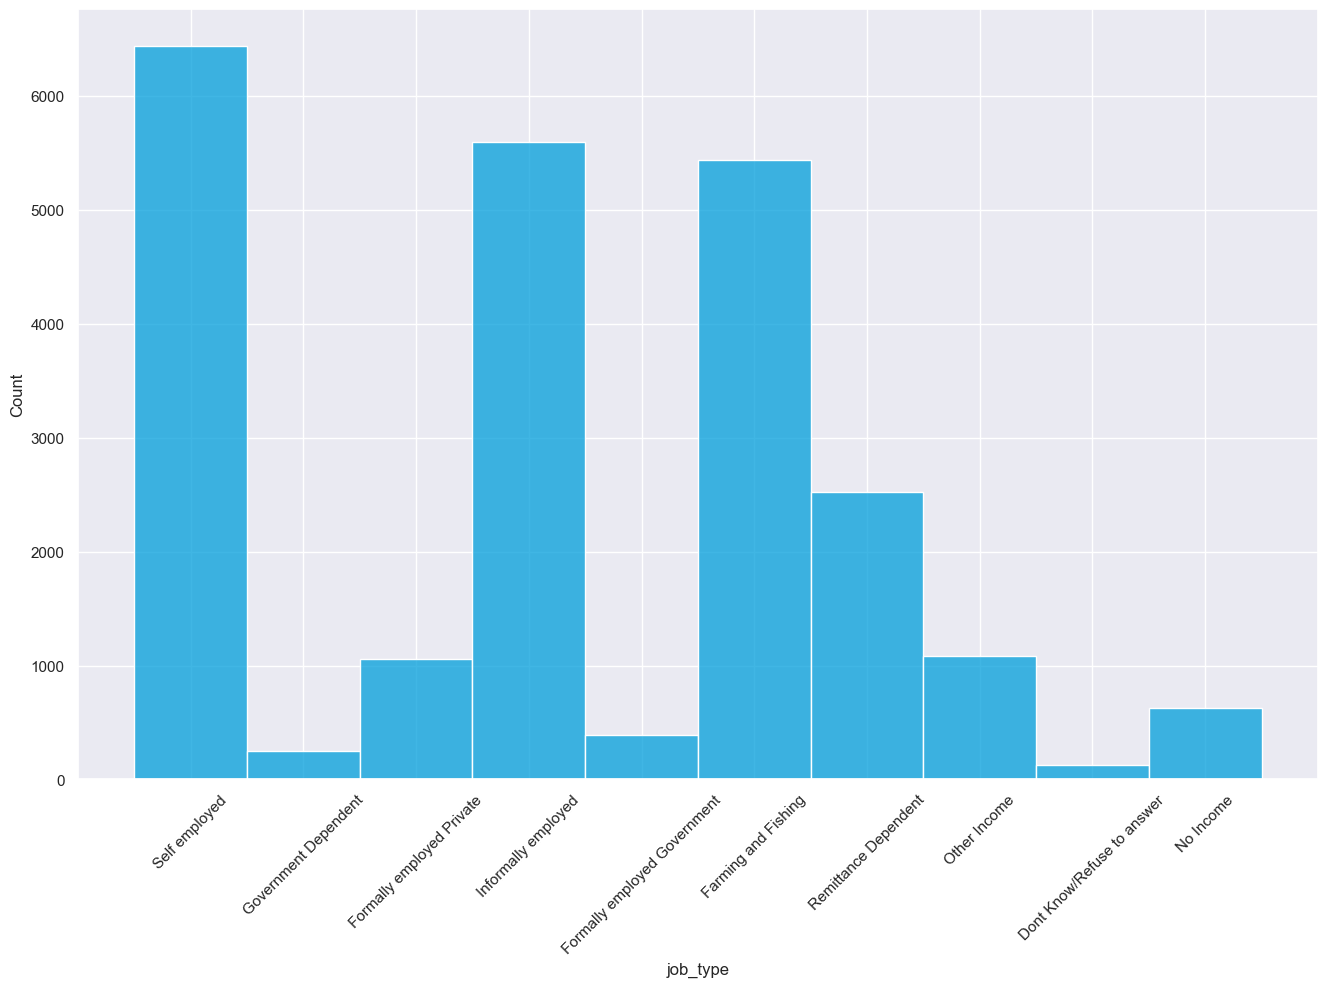

In [ ]:
# bank account job type 
sns.set(rc={'figure.figsize':(16,10)})
ax = sns.histplot(data=df, x="job_type", color="#009EDB", )#order=df.sort_values('job_type'))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)

plt.show()

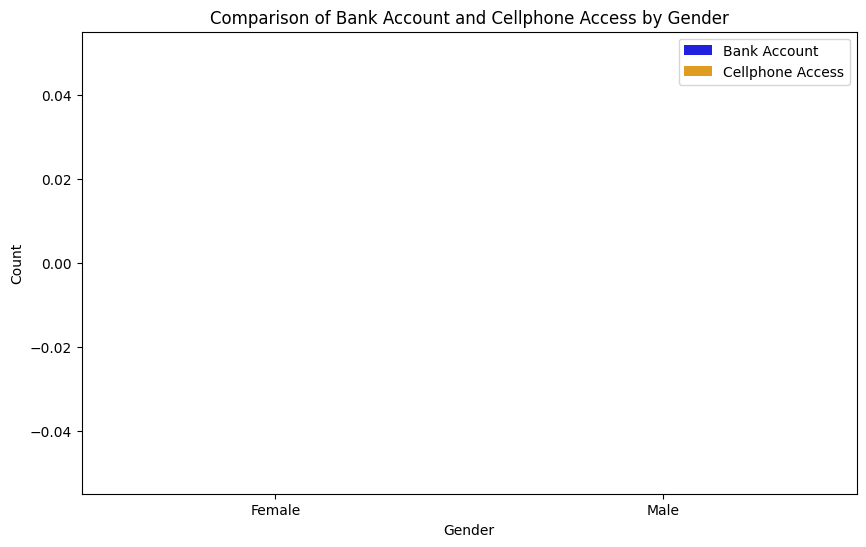

In [20]:

# Convert 'cellphone_access' and 'bank_account' columns to integers
# df['cellphone_access'] = df['cellphone_access'].astype(int)
# df['bank_account'] = df['bank_account'].astype(int)

df['cellphone_access'] = df['cellphone_access'].map(
                   {'yes':1 ,'no':0})
df['bank_account'] = df['bank_account'].map(
                   {'yes':1 ,'no':0})

#print(type(df.cellphone_access))
# Group the data by gender and sum the occurrences in each category
grouped = df.groupby('gender_of_respondent')[['bank_account', 'cellphone_access']].sum().reset_index()

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the bar plots using seaborn
sns.barplot(x='gender_of_respondent', y='bank_account', data=grouped, color='blue', label='Bank Account')
sns.barplot(x='gender_of_respondent', y='cellphone_access', data=grouped, color='orange', label='Cellphone Access')

# Add labels and title
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Comparison of Bank Account and Cellphone Access by Gender')

# Show the legend
plt.legend()

# Show the plot
plt.show()



In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

df['cellphone_access'] = df['cellphone_access'].map({'yes': 1, 'no': 0}).to_list()
df['bank_account'] = df['bank_account'].map({'yes': 1, 'no': 0}).to_list()

grouped = df.groupby('gender_of_respondent')['bank_account', 'cellphone_access'].sum().reset_index()

plt.figure(figsize=(10, 6))

sns.barplot(x='gender_of_respondent', y='bank_account', data=grouped, color='blue', label='Bank Account')
sns.barplot(x='gender_of_respondent', y='cellphone_access', data=grouped, color='orange', label='Cellphone Access')

plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Comparison of Bank Account and Cellphone Access by Gender')

plt.legend()
plt.show()


ValueError: Cannot subset columns with a tuple with more than one element. Use a list instead.

In [5]:


# Group the data by gender and count the occurrences in each category
grouped = df.groupby('gender_of_respondent')[['bank_account', 'cellphone_access']].sum()

# Get the unique genders
genders = grouped.index.tolist()

# Get the values for each category
bank_account_values = grouped['bank_account'].tolist()
cellphone_access_values = grouped['cellphone_access'].tolist()

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Set the bar width
bar_width = 0.35

# Set the position of the bars on the x-axis
r1 = range(len(genders))
r2 = [x + bar_width for x in r1]

# Plot the bank account data
plt.bar(r1, bank_account_values, color='blue', width=bar_width, edgecolor='black', label='Bank Account')

# Plot the cellphone access data
plt.bar(r2, cellphone_access_values, color='orange', width=bar_width, edgecolor='black', label='Cellphone Access')

# Add labels, title, and legend
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Comparison of Bank Account and Cellphone Access by Gender')
plt.xticks([r + bar_width/2 for r in range(len(genders))], genders)
plt.legend()

# Show the plot
plt.show()


ValueError: Image size of 294376x547 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 800x600 with 1 Axes>

In [13]:
sns.catplot(
    x='cellphone_access',
    hue=,
    col='gender_of_respondent',
    data=df,
    kind='bar',
    height=4,
    aspect=1.2,
    legend_out=False)

plt.show()

TypeError: Neither the `x` nor `y` variable appears to be numeric.

/var/folders/jr/p21bhxh16zs45yz56c_h0pbw0000gn/T/ipykernel_41560/3598653700.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)


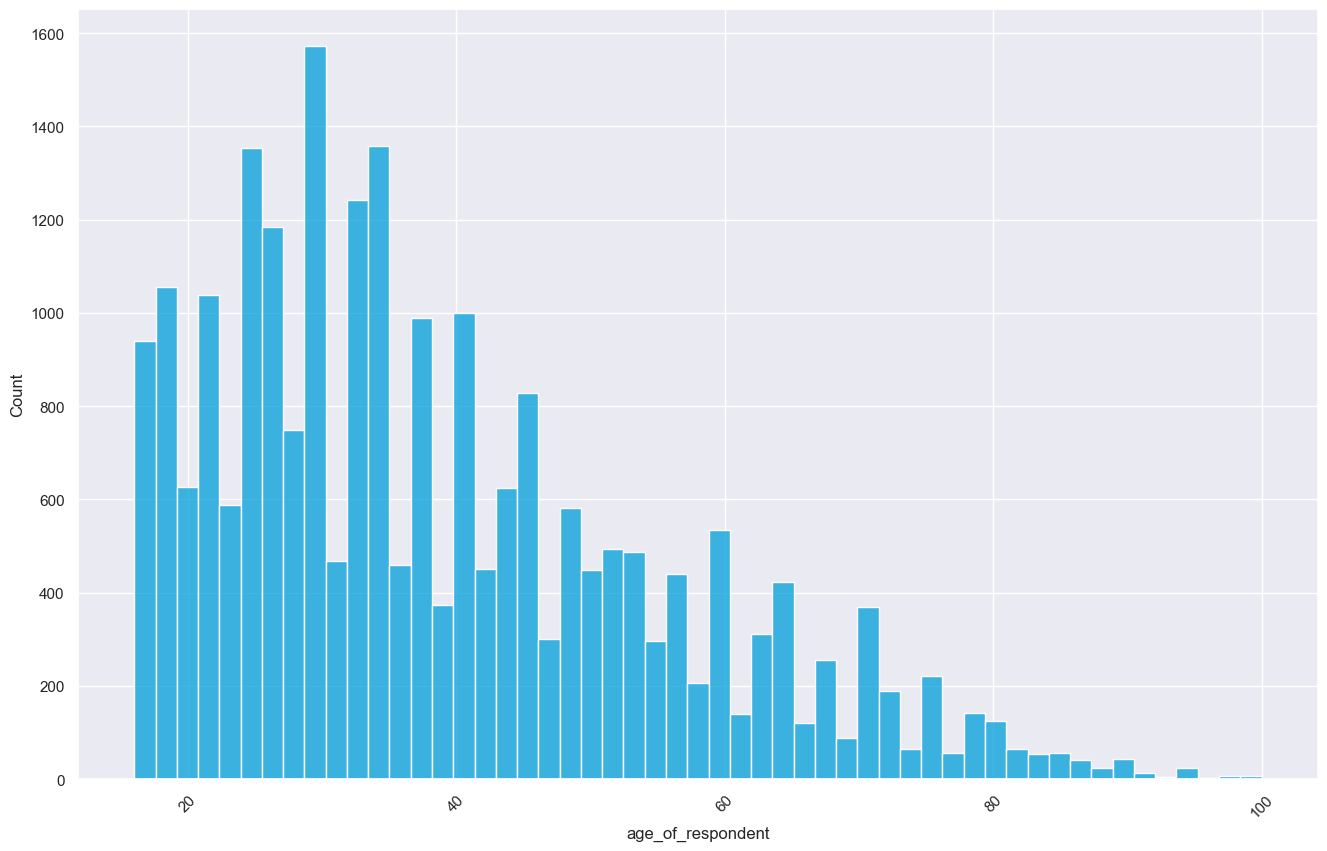

In [ ]:
# bank account 
sns.set(rc={'figure.figsize':(16,10)})
ax = sns.histplot(data=df, x="age_of_respondent", color="#009EDB", )#order=df.sort_values('job_type'))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)

plt.show()

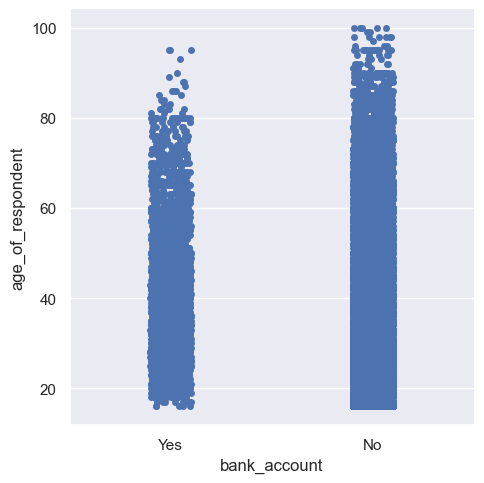

In [ ]:
sns.catplot(data=df, x="bank_account", y="age_of_respondent")

In [ ]:
sns.catplot(data=df, x="sex", y="survived", hue="class", kind="bar")


NameError: name 'sns' is not defined

In [14]:
sns.catplot(data=df, x="gender_of_respondent", y="age_of_respondent", hue="cellphone_access", kind="swarm")


/Users/fisch/neuefische/ds-ml-financial-inclusion-project/.venv/lib/python3.9/site-packages/seaborn/categorical.py:3544: UserWarning: 88.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x='bank_account',y='age_of_respondent',data=df, palette='rainbow')#, order=df.sort_values('age_of_respondent'))
plt.title("Fare of Passenger by Embarked Town")

In [ ]:
# correlation matrix

idx = ['1', '2', '3', '4']
  
# Defining columns for the dataframe
cols = list('ABCD')
  
# Entering values in the index and columns  
# and converting them into a panda dataframe
df = pd.DataFrame([[10, 20, 30, 40], [50, 30, 8, 15],
                   [25, 14, 41, 8], [7, 14, 21, 28]],
                   columns = cols, index = idx)
  
# generating pairwise correlation
corr = df.corr()
  
# Displaying dataframe as an heatmap 
# with diverging colourmap as coolwarm
corr.style.background_gradient(cmap ='coolwarm')

In [ ]:
pd.crosstab(ctdf.job_type, ctdf.education_level,normalize="index")

# There are - as expected - correlations between job and education

pd.crosstab(ctdf.country, ctdf.education_level,normalize="index")

# Feature Engineering

In [ ]:
# Convert all categories into dummies
cats = ["country", "bank_account", "location_type", "cellphone_access","gender_of_respondent", "relationship_with_head", "marital_status", "education_level", "job_type"] 
df_dumm = pd.get_dummies(df, prefix_sep="_", columns = cats ,drop_first=True)


# Drop 'uniqueid'
df_dumm.drop("uniqueid",inplace=True, axis= 1)


In [ ]:
# Train-Test-Split
y = df_dumm[["bank_account_Yes"]]
X = df_dumm.drop("bank_account_Yes", axis = 1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y) # Default 25% in test



In [ ]:
# # Min-Max-Scaling not relevant for decision trees
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# X_train_scaled


# Model

- Metric: Our stakeholder - the UN - wants an accurate and unbiased view of the banking situation in Africa. We therefore think that the accuracy - although the data is not balanced - is a good starter metric

- Baseline: To showcase the stakeholder what is possible with data science. Very simple but assumption driven. Selection of 1 or 2 features. 

Idea: Rural and no/early_education

In [ ]:
df_dumm.columns

In [ ]:
y_pred_baseline = []

X_test_scaled_df = pd.DataFrame(X_test,columns = df_dumm.drop("bank_account_Yes",axis=1).columns)

for index, row in X_test_scaled_df.iterrows():
    if row["location_type_Urban"] or row['education_level_Other/Dont know/RTA'] or row['education_level_Secondary education'] or row['education_level_Tertiary education'] or row[ 'education_level_Vocational/Specialised training']:
        y_pred_baseline.append(1)
    else:
        y_pred_baseline.append(0)

print(y_pred_baseline)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, y_pred_baseline))
print(classification_report(y_test, y_pred_baseline))

# Our baseline model has an accuracy of 55% and many false positives.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
test = DecisionTreeClassifier()

test.fit(X_train, y_train)

y_pred = test.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
np.savetxt('data/X_train_scaled.csv', X_train, delimiter=',')
np.savetxt('data/X_test_scaled.csv', X_test, delimiter=',')
np.savetxt('data/y_test.csv', y_test, delimiter=',')
np.savetxt('data/y_train.csv', y_train, delimiter=',')

In [ ]:
import imblearn

In [ ]:
# from imblearn.under_sampling import RandomUnderSampler, NearMiss

# rus = NearMiss(version=3)
# X_rus, y_rus = rus.fit_resample(X_train_scaled, y_train)



In [ ]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
# test = DecisionTreeClassifier()

# test.fit(X_rus, y_rus)

# y_pred = test.predict(X_test_scaled)

# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))

# Ideas to improve

- Get rid of year
- transform skewed numerical variables to more normally distributed values (log-scaling) -> age and number of householdmembers


- Unbalanced target variable. Play around with balanced bootstrapping: https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/